In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
# import pytesseract as pyt
import pandas as pd
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
import random
import easyocr as ocr
import os
import glob
from Levenshtein import distance
import warnings
warnings.filterwarnings("ignore")
os.chdir('/home/dell/FIR-Analysis/OCR')
reader = ocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [3]:
hand_encoder = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
hand_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

text_encoder = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
text_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [18]:
# hand_encoder.save_pretrained("models/english/hand_encoder")
# hand_processor.save_pretrained("models/english/hand_processor")
# text_encoder.save_pretrained("models/english/text_encoder")
# text_processor.save_pretrained("models/english/text_processor")

Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


In [28]:
def ocr(img, is_handwritten:bool, special_token:bool=True)->str:
    if is_handwritten:
        pixel_vals = hand_processor(img, return_tensors='pt').pixel_values
        generated_ids = hand_encoder.generate(pixel_vals)
        text = hand_processor.batch_decode(generated_ids, skip_special_tokens=special_token)[0]
    else:
        pixel_vals = text_processor(img, return_tensors='pt').pixel_values
        generated_ids = text_encoder.generate(pixel_vals)
        text = text_processor.batch_decode(generated_ids, skip_special_tokens=special_token)[0]

    return text

In [4]:
exam_rand_img = cv2.imread(random.choice(list(glob.glob('data/ability_test_ocr_and_localization/*'))))
fir_rand_img = cv2.imread(random.choice(list(glob.glob('data/fir_images_samples/*'))))

exam_rand_img = cv2.cvtColor(exam_rand_img, cv2.COLOR_BGR2RGB)
fir_rand_img = cv2.cvtColor(fir_rand_img, cv2.COLOR_BGR2RGB)

In [5]:
def plot_two(img1,img2):
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(img2)

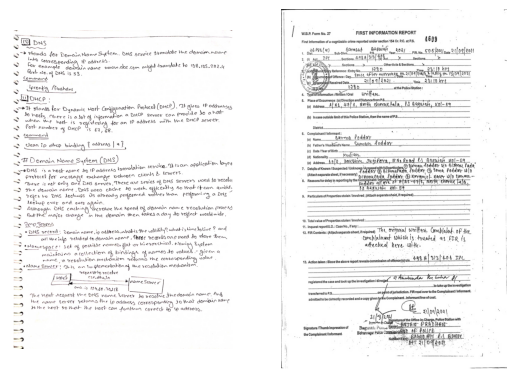

In [6]:
plot_two(exam_rand_img,fir_rand_img)

## EasyOCR

In [7]:
data_exam = np.array(reader.detect(exam_rand_img)[0][0])
data_fir = np.array(reader.detect(fir_rand_img)[0][0])

easy_exam_img = exam_rand_img.copy()
easy_fir_img = fir_rand_img.copy()

In [8]:
data_exam[0][0]

116

In [9]:
df_exam_data = pd.DataFrame(data_exam, columns=['x_min', 'x_max', 'y_min', 'y_max'])
df_fir_data = pd.DataFrame(data_fir, columns=['x_min', 'x_max', 'y_min', 'y_max'])
df_fir_data['text'] = pd.NA
df_exam_data['text'] = pd.NA

In [29]:
fir_text = []
exam_text = []
for i in range(df_exam_data.shape[0]):
    x_min, x_max, y_min, y_max = df_exam_data.iloc[i]['x_min'], df_exam_data.iloc[i]['x_max'], df_exam_data.iloc[i]['y_min'], df_exam_data.iloc[i]['y_max']
    text = ocr(exam_rand_img[y_min:y_max,x_min:x_max], True)
    df_exam_data.loc[i, 'text'] = text
    easy_exam_img = cv2.rectangle(easy_exam_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

for i in range(df_fir_data.shape[0]):
    x_min, x_max, y_min, y_max = df_fir_data.iloc[i]['x_min'], df_fir_data.iloc[i]['x_max'], df_fir_data.iloc[i]['y_min'], df_fir_data.iloc[i]['y_max']
    text = ocr(fir_rand_img[y_min:y_max,x_min:x_max], False)
    df_fir_data.loc[i, 'text'] = text
    easy_fir_img = cv2.rectangle(easy_fir_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)


In [12]:
def are_similar(str1, str2, threshold=0.6):
    similarity = 1 - distance(str1,str2) / max(len(str1), len(str2))
    print(similarity)
    return similarity >= threshold

# Example usage
str1 = "hello"
str2 = "hello"
if are_similar(str1, str2):
    print(f"{str1} and {str2} are similar.")
else:
    print(f"{str1} and {str2} are not similar.")

1.0
hello and hello are similar.
